In [72]:
import pandas as pd
import numpy as np
import os, pickle
import json
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

In [73]:
import eli5

In [74]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.optimizers import Adam  

In [75]:
def custom_sum(x):
  """
  This function checks if the value is in the skip list and returns 0 if it is.
  Otherwise, it returns the value itself.
  """
  skip_values = [5, 7]  # Values to exclude from cumulative sum
  if x in skip_values:
    return 0
  else:
    return x

In [95]:
data1=[]
rootdir = 'T20_matches'
cnt=0
for subdir, dirs, files in os.walk(rootdir):
    # print(dirs)
    # if(cnt>=50):
    #     break
    try: 
        for file in files:
            # print(cnt)
            if(file[-1]=='v'):
                continue
            # if(cnt>=50):
            #     break
            if file.endswith('2.pkl'):
                # print(os.path.join(subdir,"match_info.json"))
                # print(cnt)
                with open(os.path.join(subdir,file), 'rb') as f:
                    # print("here")
                    data1 = (pickle.load(f))
                    with open(os.path.join(subdir,"match_info.json")) as file:
                        match_info = json.load(file)
                        # print("here")
                    if cnt==0:
                        df1 = pd.DataFrame(data1,columns=['bowler', 'batsman', 'wickets', 'over', 'outcome'])
                        df1['batting_team'] = match_info['Second Innings']
                        df1['bowling_team'] = match_info['First Innings']
                        df1['venue'] = match_info['Stadium Name']
                        df1['toss_won'] = int(match_info['Toss Winner'] == match_info['Second Innings'])
                        df1['target_score'] = int(match_info['First Innings runs'])
                        df1['runs'] = df1['outcome'].apply(custom_sum).cumsum() 
                        # print("df1.head()")
                    else:
                        dft = pd.DataFrame(data1,columns=['bowler', 'batsman', 'wickets', 'over', 'outcome'])
                        dft['batting_team'] = match_info['Second Innings']
                        dft['bowling_team'] = match_info['First Innings']
                        dft['venue'] = match_info['Stadium Name']
                        dft['toss_won'] = int(match_info['Toss Winner'] == match_info['Second Innings'])
                        dft['target_score'] = int(match_info['First Innings runs'])
                        dft['runs'] = dft['outcome'].apply(custom_sum).cumsum() 
                        df1 = pd.concat([df1,dft],ignore_index=True)
                    cnt+=1
                    
    except: 
        pass

In [96]:
df1

,bowler,batsman,wickets,over,outcome,batting_team,bowling_team,venue,toss_won,target_score,runs
0,Tait_Australia,Imrul_Bangladesh,0,1,0,Bangladesh,Australia,"Kensington Oval, Bridgetown, Barbados",0,141,0
1,Tait_Australia,Imrul_Bangladesh,0,1,0,Bangladesh,Australia,"Kensington Oval, Bridgetown, Barbados",0,141,0
2,Tait_Australia,Imrul_Bangladesh,0,1,4,Bangladesh,Australia,"Kensington Oval, Bridgetown, Barbados",0,141,4
3,Tait_Australia,Imrul_Bangladesh,0,1,0,Bangladesh,Australia,"Kensington Oval, Bridgetown, Barbados",0,141,4
4,Tait_Australia,Imrul_Bangladesh,0,1,0,Bangladesh,Australia,"Kensington Oval, Bridgetown, Barbados",0,141,4
...,...,...,...,...,...,...,...,...,...,...,...
27084,Tanvir_Pakistan,Chigumbura_Zimbabwe,6,20,0,Zimbabwe,Pakistan,Harare Sports Club,1,179,154
27085,Tanvir_Pakistan,Chigumbura_Zimbabwe,6,20,0,Zimbabwe,Pakistan,Harare Sports Club,1,179,154
27086,Tanvir_Pakistan,Chigumbura_Zimbabwe,6,20,4,Zimbabwe,Pakistan,Harare Sports Club,1,179,158
27087,Tanvir_Pakistan,Chigumbura_Zimbabwe,6,20,1,Zimbabwe,Pakistan,Harare Sports Club,1,179,159


In [97]:
cat_cols = ['bowler', 'batsman', 'batting_team', 'bowling_team', 'venue']
for category in cat_cols:
    df1[category] = pd.Categorical(df1[category])
    df1[category+"_idx"] = df1[category].cat.codes
df1

,bowler,batsman,wickets,over,outcome,batting_team,bowling_team,venue,toss_won,target_score,runs,bowler_idx,batsman_idx,batting_team_idx,bowling_team_idx,venue_idx
0,Tait_Australia,Imrul_Bangladesh,0,1,0,Bangladesh,Australia,"Kensington Oval, Bridgetown, Barbados",0,141,0,259,129,1,0,19
1,Tait_Australia,Imrul_Bangladesh,0,1,0,Bangladesh,Australia,"Kensington Oval, Bridgetown, Barbados",0,141,0,259,129,1,0,19
2,Tait_Australia,Imrul_Bangladesh,0,1,4,Bangladesh,Australia,"Kensington Oval, Bridgetown, Barbados",0,141,4,259,129,1,0,19
3,Tait_Australia,Imrul_Bangladesh,0,1,0,Bangladesh,Australia,"Kensington Oval, Bridgetown, Barbados",0,141,4,259,129,1,0,19
4,Tait_Australia,Imrul_Bangladesh,0,1,0,Bangladesh,Australia,"Kensington Oval, Bridgetown, Barbados",0,141,4,259,129,1,0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27084,Tanvir_Pakistan,Chigumbura_Zimbabwe,6,20,0,Zimbabwe,Pakistan,Harare Sports Club,1,179,154,260,55,9,5,16
27085,Tanvir_Pakistan,Chigumbura_Zimbabwe,6,20,0,Zimbabwe,Pakistan,Harare Sports Club,1,179,154,260,55,9,5,16
27086,Tanvir_Pakistan,Chigumbura_Zimbabwe,6,20,4,Zimbabwe,Pakistan,Harare Sports Club,1,179,158,260,55,9,5,16
27087,Tanvir_Pakistan,Chigumbura_Zimbabwe,6,20,1,Zimbabwe,Pakistan,Harare Sports Club,1,179,159,260,55,9,5,16


In [98]:
df2 = df1[['bowler_idx', 'batsman_idx', 'wickets', 'over', 'batting_team_idx', 'bowling_team_idx', 'venue_idx', 'toss_won','runs', 'target_score', 'outcome']]

In [99]:
def create_sequences(df, max_len):
  """
  This function extracts sequences of a fixed length from a Pandas DataFrame 
  containing cricket match data and creates sequences with arrays of features.

  Args:
      df: A Pandas DataFrame containing cricket match data (e.g., batsman, bowler, outcome for each ball).
      max_len: The desired length of each sequence (number of balls).

  Returns:
      A numpy array of shape (num_sequences, max_len, features) containing sequences.
  """

  sequences = []
  for i in range(df.shape[0] - max_len + 1):  # Slide window approach
    sequence = []
    for j in range(i, i + max_len):
      # Access data for each ball using row indexing
      ball_data = df.iloc[j]
      # Create a numpy array of features for this ball
      features = np.array([ball_data[col] for col in df.columns if col not in ['index','bowler', 'batsman', 'batting_team', 'bowling_team', 'venue']])  # Exclude index column
      sequence.append(features)  # Append array of features to sequence
    sequences.append(sequence)

  # Convert sequences to numpy array (no reshape needed here)
  sequences = np.array(sequences)
  return sequences

def get_target_variable(sequence):
  """
  This function retrieves the target variable (outcome of the next ball) 
  corresponding to a sequence of balls.

  Args:
      sequence: A list representing a sequence of balls (features for each ball).

  Returns:
      The target variable (outcome of the next ball) encoded as needed.
  """
  # Assuming the outcome is the last element in the sequence (modify as needed)
  target_variable = sequence[-1][-1]
  # Encode the target variable (e.g., one-hot encoding for multi-class classification)
  # ... (your target variable encoding logic) ...
  return target_variable

In [100]:
# Define parameters (replace with your values)
max_len = 12  # Maximum sequence length (number of balls)
num_features = 10  # Total number of features after encoding (replace with actual number)

In [101]:
sequences = create_sequences(df2, max_len)
target_variables = []
for sequence in sequences:  # Function to create sequences of length max_len
    target_variables.append(get_target_variable(sequence)) 

In [102]:
sequences

array([[[259, 129,   0, ...,   0, 141,   0],
        [259, 129,   0, ...,   0, 141,   0],
        [259, 129,   0, ...,   4, 141,   4],
        ...,
        [178, 291,   2, ...,   6, 141,   2],
        [178, 291,   2, ...,   6, 141,   0],
        [178, 291,   2, ...,   7, 141,   1]],

       [[259, 129,   0, ...,   0, 141,   0],
        [259, 129,   0, ...,   4, 141,   4],
        [259, 129,   0, ...,   4, 141,   0],
        ...,
        [178, 291,   2, ...,   6, 141,   0],
        [178, 291,   2, ...,   7, 141,   1],
        [259, 291,   2, ...,   7, 141,   0]],

       [[259, 129,   0, ...,   4, 141,   4],
        [259, 129,   0, ...,   4, 141,   0],
        [259, 129,   0, ...,   4, 141,   0],
        ...,
        [178, 291,   2, ...,   7, 141,   1],
        [259, 291,   2, ...,   7, 141,   0],
        [259, 291,   2, ...,   8, 141,   1]],

       ...,

       [[260,  55,   5, ..., 136, 179,   1],
        [260, 353,   5, ..., 137, 179,   1],
        [ 17, 353,   5, ..., 137, 179,   0

In [103]:
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', value=-1)
padded_sequences

array([[[259, 129,   0, ...,   0, 141,   0],
        [259, 129,   0, ...,   0, 141,   0],
        [259, 129,   0, ...,   4, 141,   4],
        ...,
        [178, 291,   2, ...,   6, 141,   2],
        [178, 291,   2, ...,   6, 141,   0],
        [178, 291,   2, ...,   7, 141,   1]],

       [[259, 129,   0, ...,   0, 141,   0],
        [259, 129,   0, ...,   4, 141,   4],
        [259, 129,   0, ...,   4, 141,   0],
        ...,
        [178, 291,   2, ...,   6, 141,   0],
        [178, 291,   2, ...,   7, 141,   1],
        [259, 291,   2, ...,   7, 141,   0]],

       [[259, 129,   0, ...,   4, 141,   4],
        [259, 129,   0, ...,   4, 141,   0],
        [259, 129,   0, ...,   4, 141,   0],
        ...,
        [178, 291,   2, ...,   7, 141,   1],
        [259, 291,   2, ...,   7, 141,   0],
        [259, 291,   2, ...,   8, 141,   1]],

       ...,

       [[260,  55,   5, ..., 136, 179,   1],
        [260, 353,   5, ..., 137, 179,   1],
        [ 17, 353,   5, ..., 137, 179,   0

In [104]:
padded_sequences[0][-1]

array([178, 291,   2,   2,   1,   0,  19,   0,   7, 141,   1])

In [105]:
X_train = []
y_train = []
outcome_index = -1  # Assuming outcome is the last element in each sequence
for sequence in sequences:
    # Extract features (excluding outcome)
    # features = [element for element in sequence[:-1] if element != sequence[outcome_index]]  # List comprehension for selective exclusion
    # X_train.append(sequence[:-1][:,:-1])
    X_train.append(sequence[:,:-1])
    
    # Extract target variable (outcome)
    target = sequence[-1][outcome_index]
    y_train.append(target)


In [106]:
X_train = np.array(X_train)
X_train.shape

(27078, 12, 10)

In [107]:
y_train = np.array(y_train)
y_train.shape

(27078,)

In [108]:
n_train_time = int(0.8 * X_train.shape[0])
X_train ,X_test = X_train[:n_train_time], X_train[n_train_time:]
print(X_train.shape, X_test.shape)
y_train, y_test = y_train[:n_train_time], y_train[n_train_time:]
print(y_train.shape, y_test.shape)

(21662, 12, 10) (5416, 12, 10)
(21662,) (5416,)


In [109]:
y_train1= (pd.get_dummies(pd.DataFrame(y_train, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values)

In [110]:
y_test1= (pd.get_dummies(pd.DataFrame(y_test, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values) 

In [111]:
y_train1.shape

(21662, 8)

In [112]:
pd.DataFrame(y_train).value_counts()

1    8609
0    6915
4    2355
2    1675
7    1114
6     818
3     144
5      32
dtype: int64

Epoch 1/100
677/677 - 14s - loss: 1.5056 - accuracy: 0.3994 - val_loss: 1.4696 - val_accuracy: 0.4226 - 14s/epoch - 20ms/step
Epoch 2/100
677/677 - 8s - loss: 1.4859 - accuracy: 0.4143 - val_loss: 1.4640 - val_accuracy: 0.4308 - 8s/epoch - 12ms/step
Epoch 3/100
677/677 - 8s - loss: 1.4780 - accuracy: 0.4250 - val_loss: 1.4623 - val_accuracy: 0.4291 - 8s/epoch - 11ms/step
Epoch 4/100
677/677 - 8s - loss: 1.4759 - accuracy: 0.4266 - val_loss: 1.4621 - val_accuracy: 0.4260 - 8s/epoch - 12ms/step
Epoch 5/100
677/677 - 8s - loss: 1.4718 - accuracy: 0.4308 - val_loss: 1.4616 - val_accuracy: 0.4213 - 8s/epoch - 12ms/step
Epoch 6/100
677/677 - 8s - loss: 1.4693 - accuracy: 0.4313 - val_loss: 1.4596 - val_accuracy: 0.4315 - 8s/epoch - 12ms/step
Epoch 7/100
677/677 - 8s - loss: 1.4677 - accuracy: 0.4313 - val_loss: 1.4604 - val_accuracy: 0.4308 - 8s/epoch - 11ms/step
Epoch 8/100
677/677 - 8s - loss: 1.4657 - accuracy: 0.4339 - val_loss: 1.4590 - val_accuracy: 0.4324 - 8s/epoch - 13ms/step
Epoch 

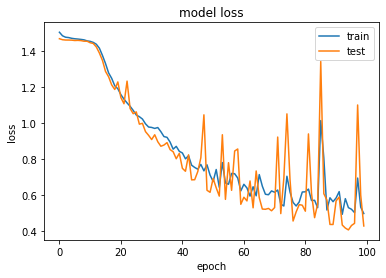

In [113]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))

#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(8, activation='softmax'))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# fit network
history = model.fit(X_train, y_train1, epochs=100, batch_size=32, validation_data=(X_test, y_test1), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [114]:
def permute_importance(x,y,model,feature):
    """
    This function calculates the permutation importance of a feature in a model.
    
    Args:
        x: A numpy array containing the input features.
        y: A numpy array containing the target variable.
        model: A trained machine learning model.
        feature: The feature for which to calculate the permutation importance.
        
    Returns:
        The permutation importance of the feature.
    """
    baseline = model.evaluate(x, y, verbose=0)[1]  # Baseline accuracy
    x_copy = x.copy()  # Create a copy of the input features
    shuffle_column = x_copy[:, feature]  # Extract the feature to be permuted
    x_copy[:, feature] = np.random.permutation(shuffle_column)  # Permuted feature
    permuted_score = model.evaluate(x_copy, y, verbose=0)[1]  # Score with permuted feature
    return baseline - permuted_score  # Permutation importance

In [118]:
colss = df2.columns.to_list()
for i in range(0,10):
    print(f"{colss[i]} : {permute_importance(X_test, y_test1,model,i)}")

bowler_idx : 0.04855978488922119
batsman_idx : 0.05428361892700195
wickets : 0.09619647264480591
over : 0.09176510572433472
batting_team_idx : 0.1194608211517334
bowling_team_idx : 0.21916544437408447
venue_idx : 0.28138846158981323
toss_won : 0.3609675168991089
runs : 0.4634416401386261
target_score : 0.5579763650894165


In [185]:
# df_team1 = df2[df2['batting_team_idx'] == 0]
# sequences = create_sequences(df_team1, 10)
# target_variables = []
# for sequence in sequences:  # Function to create sequences of length max_len
#     target_variables.append(get_target_variable(sequence)) 

# padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', value=-1)
# padded_sequences
# X_train = []
# y_train = []
# outcome_index = -1  # Assuming outcome is the last element in each sequence
# for sequence in sequences:
#     # Extract features (excluding outcome)
#     # features = [element for element in sequence[:-1] if element != sequence[outcome_index]]  # List comprehension for selective exclusion
#     # X_train.append(sequence[:-1][:,:-1])
#     X_train.append(sequence[:,:-1])
    
#     # Extract target variable (outcome)
#     target = sequence[-1][outcome_index]
#     y_train.append(target)
# X_train = np.array(X_train)
# y_train = np.array(y_train)
# n_train_time = int(0.8 * X_train.shape[0])
# X_train ,X_test = X_train[:n_train_time], X_train[n_train_time:]
# print(X_train.shape, X_test.shape)
# y_train, y_test = y_train[:n_train_time], y_train[n_train_time:]
# y_train1= (pd.get_dummies(pd.DataFrame(y_train, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values)
# y_test1= (pd.get_dummies(pd.DataFrame(y_test, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values) 

(3111, 10, 9) (778, 10, 9)


In [152]:
y_test1.shape

(778, 7)

Epoch 1/100


/Users/rahul/miniconda3/envs/btp/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


389/389 - 4s - 10ms/step - accuracy: 0.3815 - loss: 1.5960 - val_accuracy: 0.4023 - val_loss: 1.5408
Epoch 2/100
389/389 - 2s - 5ms/step - accuracy: 0.4008 - loss: 1.5494 - val_accuracy: 0.4139 - val_loss: 1.5313
Epoch 3/100
389/389 - 2s - 5ms/step - accuracy: 0.4079 - loss: 1.5389 - val_accuracy: 0.4010 - val_loss: 1.5263
Epoch 4/100
389/389 - 2s - 5ms/step - accuracy: 0.4188 - loss: 1.5298 - val_accuracy: 0.3997 - val_loss: 1.5348
Epoch 5/100
389/389 - 2s - 5ms/step - accuracy: 0.4131 - loss: 1.5232 - val_accuracy: 0.4075 - val_loss: 1.5327
Epoch 6/100
389/389 - 2s - 5ms/step - accuracy: 0.4221 - loss: 1.5207 - val_accuracy: 0.4126 - val_loss: 1.5226
Epoch 7/100
389/389 - 2s - 5ms/step - accuracy: 0.4201 - loss: 1.5186 - val_accuracy: 0.3985 - val_loss: 1.5229
Epoch 8/100
389/389 - 2s - 5ms/step - accuracy: 0.4262 - loss: 1.5154 - val_accuracy: 0.4126 - val_loss: 1.5273
Epoch 9/100
389/389 - 2s - 5ms/step - accuracy: 0.4198 - loss: 1.5093 - val_accuracy: 0.4036 - val_loss: 1.5280
Epo

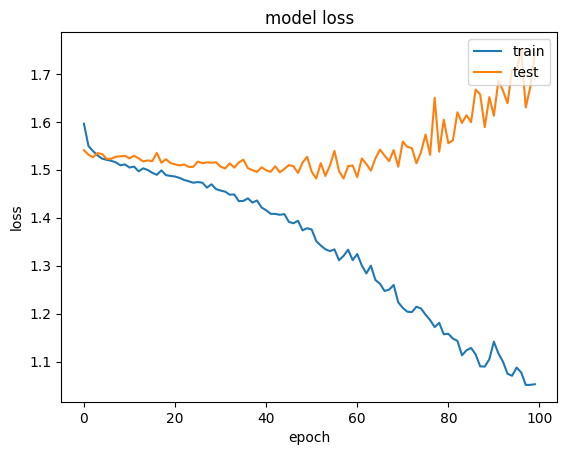

In [186]:
# model = Sequential()
# model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# # model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))

# #    model.add(LSTM(70))
# #    model.add(Dropout(0.3))
# model.add(LSTM(units=64))
# model.add(Dropout(0.5))
# # model.add(LSTM(units=32))
# # model.add(Dropout(0.2))

# # model.add(Dense(1, activation='sigmoid'))
# model.add(Dense(7, activation='softmax'))
# # model.add(Dense(1))
# # model.compile(loss='mean_squared_error', optimizer='adam')
# optimizer = Adam(learning_rate=0.01)  # Replace 0.001 with your desired learning rate

# # model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# # fit network
# history = model.fit(X_train, y_train1, epochs=100, batch_size=8, validation_data=(X_test, y_test1), verbose=2, shuffle=False)

# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.show()


In [ ]:
#DROP OUTCOME =5 remember important

In [87]:
yhat = model.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, yhat))

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean squared error: 3.97


In [34]:
df1['bowler'].value_counts()

bowler
Broad         192
Dernbach      144
Malinga       135
Shakib        132
Razzak        132
             ... 
Waller          6
Woakes          6
Ziaur           6
Sajedul         6
du Plessis      2
Name: count, Length: 143, dtype: int64

In [6]:
match_info

{'Stadium Name': 'Trent Bridge, Nottingham',
 'Toss Winner': 'West Indies',
 'First Innings': 'West Indies',
 'Second Innings': 'England',
 'First Innings runs': '172',
 'Second Innings runs': '173',
 'First Innings Wickets': '4',
 'Second Innings Wickets': '3',
 'Winner': 'England'}